In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import utilities as ut
import plant_pol_inference_Hugo_Tati as pp

In [2]:
filename = "eco-foodweb-baywet.txt"  # <-- Make sure this is the correct path to your file
delimiter = None       # Use whitespace as delimiter (split() with None handles multiple spaces)
comment_char = "#"     # Lines starting with '%' are comments

In [3]:
# Call the function to load the weighted adjacency matrix
weighted_adj_matrix, total_num_nodes_in_network = pp.read_weighted_edgelist_to_sparse_adjacency(filename, delimiter, comment_char)


Successfully read 2106 edges.
Max node ID found: 128. Creating a 128x128 matrix.


In [4]:
weighted_adj_matrix.toarray()

array([[ 0.      ,  5.217257, 73.88673 , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ]])

In [5]:
M = weighted_adj_matrix.toarray()

Since the original code and methods were developed for counting data, we transform the float edges into integers

In [6]:
M=M.astype(int)

In [7]:
np.diag(M)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [8]:

M = ut.sort(M, M)
n_p = M.shape[0]
n_a = M.shape[1]

In [9]:
n_p

128

In [10]:
n_a

128

Let's visualize it:

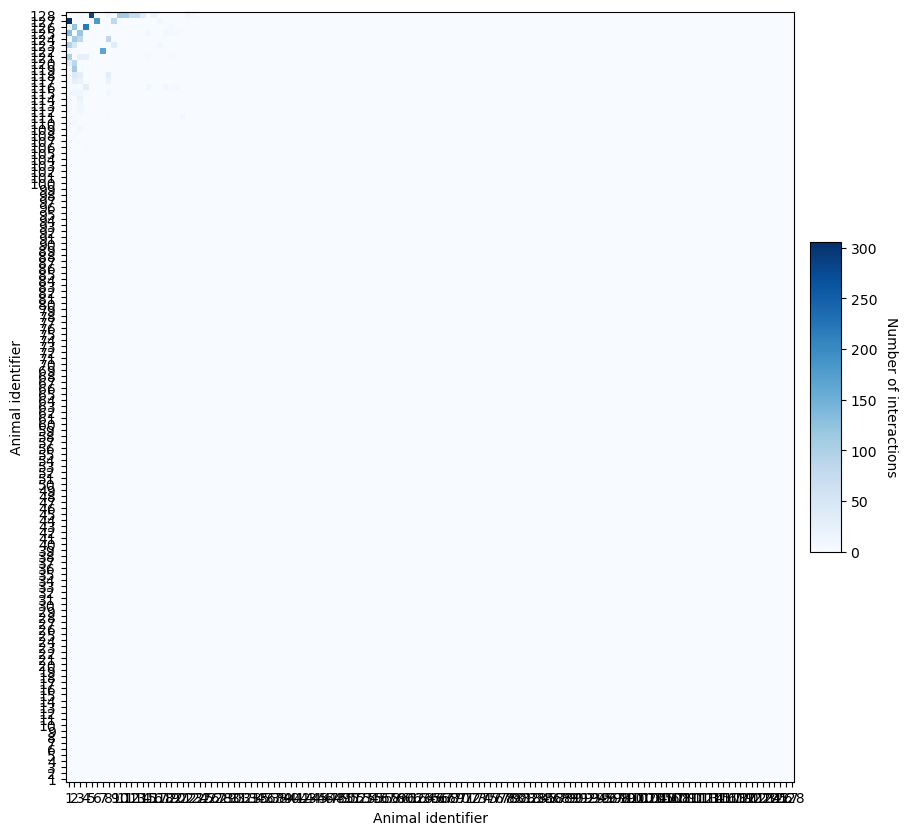

In [12]:
plt.figure(figsize=(10,10))
plt.pcolormesh(M, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Animal identifier')
plt.ylabel('Animal identifier')
plt.show()

## Pystan model

In `pystan`, we write the statistical model in a separate file.
In our case, it looks like:

In [13]:
with open('model.stan', 'r') as f:
    print(f.read())

data {
  // Dimensions of the data matrix, and matrix itself.
  int<lower=1> n_p;
  int<lower=1> n_a;
  int<lower=0> M[n_p, n_a];
}
transformed data {
  // Pre-compute the marginals of M to save computation in the model loop.
  int M_rows[n_p] = rep_array(0, n_p);
  int M_cols[n_a] = rep_array(0, n_a);
  int M_tot = 0;
  for (i in 1:n_p) {
    for (j in 1:n_a) {
      M_rows[i] += M[i, j];
      M_cols[j] += M[i, j];
      M_tot += M[i, j];
    }
  }
}
parameters {
  real<lower=0> C;
  real<lower=0> r;
  simplex[n_p] sigma;
  simplex[n_a] tau;
  real<lower=0, upper=1> rho;
}
model {
  // Global sums and parameters
  target += M_tot * log(C) - C;
  // Weighted marginals of the data matrix 
  for (i in 1:n_p) {
    target += M_rows[i] * log(sigma[i]);
  }
  for (j in 1:n_a) {
    target += M_cols[j] * log(tau[j]);
  }
  // Pairwise loop
  for (i in 1:n_p) {
    for (j in 1:n_a) {
      real nu_ij_0 = log(1 - rho);
      real nu_ij_1 = log(rho) + M[i,j] * log(1 + r) - C * r * sigma[i] * t

The `data` block contains the model parameters, in our case the dimension of the observation matrix, and the matrix itself.

The `transformed data` block allows us to calculate quantities that we'll use later. Here, we calculate the row and column sums of M, as well as its total sum.

The `parameter` block contains... well.. the parameters of the model.
These parameters are the ones that will be sampled by `Stan`, and returned to us  once we run the program.
`sigma` and `tau` are of the "simplex" type---just a synonym for normalized distributions.

The `model` block calculates the log-posterior of the model. We accumulate this value in the variable `target`.

The `generated quantities` block contains other quantities, functions of the sampled parameters, that will be returned to us once we run the program. In this case, we generate the matrix Q of edge probabilities given the parameters.

---

## Compiling the model

To  start using the model, we first need to "compile" it.
During compilation, `pystan` builds an executable whose purpose is to generate samples from our model, given an input.
Compilation takes a bit of time, but we only need to compile the model once. We are free to re-use it as many times as we like afterwards.

Our module `plant_pol_inference` (imported as `pp`) provides utilities to handle this.

In [14]:
model = pp.load_model()

c:\Users\hugog\Desktop\Master_Courses\Complex_Networks\Project\jg-you-plant-pollinator-inference-1541aeb\model.bin [Skipping --- already compiled]


## Sampling

With the model compiled, we are ready to generate our first samples.

Our `plant_pol_inference` module also provide utilities that handle this.

In [19]:
samples = pp.generate_sample(M, model, warmup=2000, num_samples=500)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


The warnings above indicate that at least one chain has gotten stuck in a minima.

We can see this by plotting the value of the posterior distribution, evaluated for each samples.

Note that in this plot, vertical lines separate Markov chains: All samples between two of these lines are generated sequentially, by an independent chain.

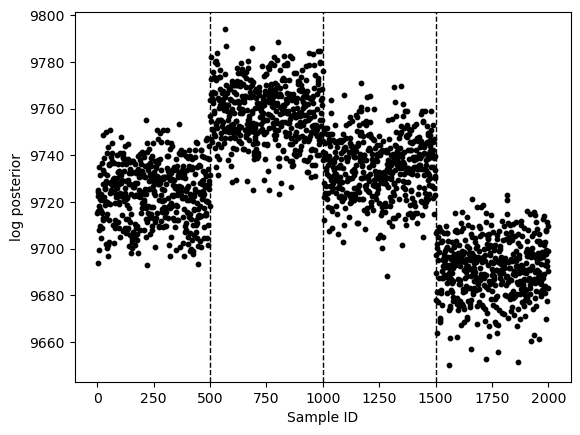

In [ ]:
plt.scatter(range(2000), samples['lp__'], s=10, c='k')
for sep in [500, 1000, 1500]:
    plt.axvline(sep, c='k', ls='--', lw=1)
plt.xlabel('Sample ID')
plt.ylabel('log posterior')
plt.show()

Not needed given the diagnostic analysis results

while not pp.test_samples(samples, tol=0.05):
    samples = pp.generate_sample(M, model, warmup=2000, num_samples=500)

plt.scatter(range(2000), samples['lp__'], s=10, c='k')
for sep in [500, 1000, 1500]:
    plt.axvline(sep, c='k', ls='--', lw=1)
plt.xlabel('Sample ID')
plt.ylabel('log posterior')
plt.show()

Here's the summary of our succesful sampling procedure:

In [21]:
samples


For the full summary use 'print(fit)'

Inference for Stan model: plant_pol_e215d9f28a31a5a7790444e1b0d7f7ff.
4 chains, each with iter=2500; warmup=2000; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
C          45.88     nan  21.44    16.9  25.76  43.63  64.67  83.99    nan    nan
r         5947.9     nan 9014.6  723.54  979.9 1559.9 4528.5  3.2e4    nan    nan
sigma[1]  5.3e-3     nan 5.8e-3  1.3e-4 1.3e-3 3.2e-3 7.2e-3   0.02    nan    nan
sigma[2]  4.9e-3     nan 5.4e-3  9.4e-5 1.2e-3 3.1e-3 6.9e-3   0.02    nan    nan
sigma[3]  5.0e-3     nan 5.1e-3  1.4e-4 1.4e-3 3.4e-3 7.0e-3   0.02    nan    nan
sigma[4]  5.3e-3     nan 5.6e-3 10.0e-5 1.2e-3 3.3e-3 7.4e-3   0.02    nan    nan
sigma[5]  5.0e-3     nan 5.2e-3  6.8e-5 1.4e-3 3.2e-3 6.8e-3   0.02    nan    nan
sigma[6]  4.9e-3     nan 5.3e-3  1.1e-4 1.2e-3 3.1e-3 6.6e-3   0.02    nan    nan
sigma[7]  4.9e-3     nan 5.2e-3  1.

In [ ]:
#Saving the model
import pickle
filename = 'stan_model_fit_foodweb_baywet.pkl'
try:
    with open(filename, 'wb') as f:
        pickle.dump(samples, f)
    print(f"Stan fit object successfully saved to {filename}")
except Exception as e:
    print(f"Error saving fit object: {e}")

Stan fit object successfully saved to stan_model_fit_foodweb_baywet.pkl


In [15]:
import pickle
filename = 'stan_model_fit_foodweb_baywet.pkl'

samples = None
try:
    with open(filename, 'rb') as f:
        samples = pickle.load(f)
    print(f"Stan fit object successfully loaded from {filename}")

except FileNotFoundError:
    print(f"Error loading fit object: File not found at {filename}")
except Exception as e:
    print(f"Error loading fit object: {e}")

Stan fit object successfully loaded from stan_model_fit_foodweb_baywet.pkl


## Posterior-predictive check

We provide a simple function that calculates the posterior predictive matrix.

In [17]:
M_tilde = pp.get_posterior_predictive_matrix(samples)

Let's compare it with the input

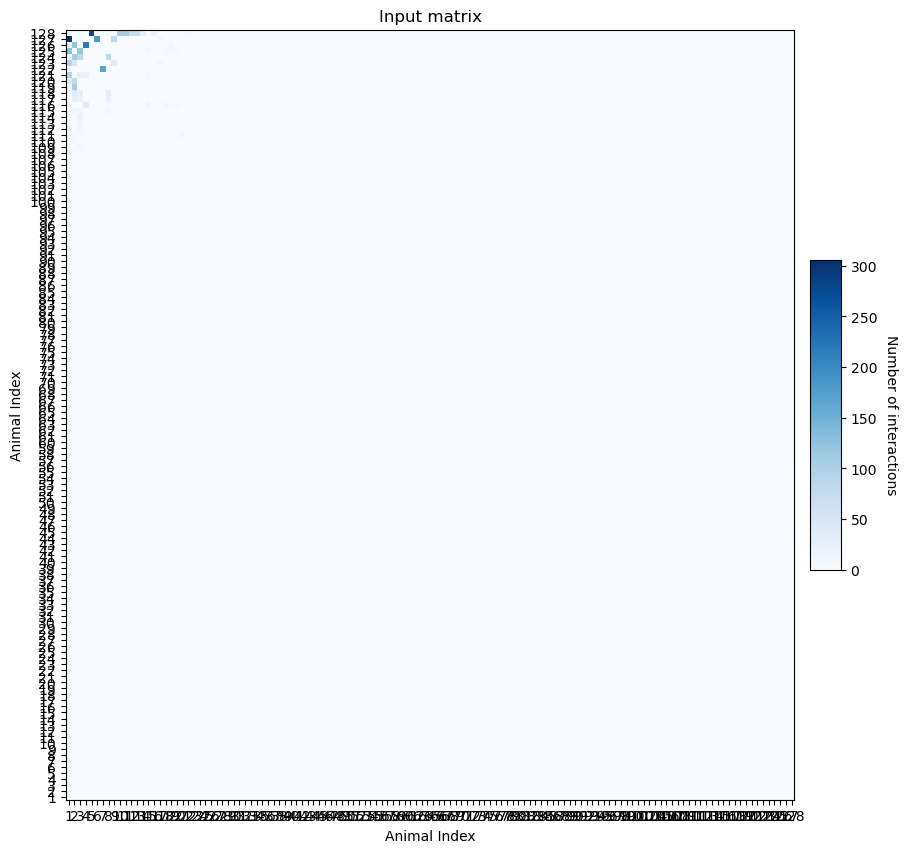

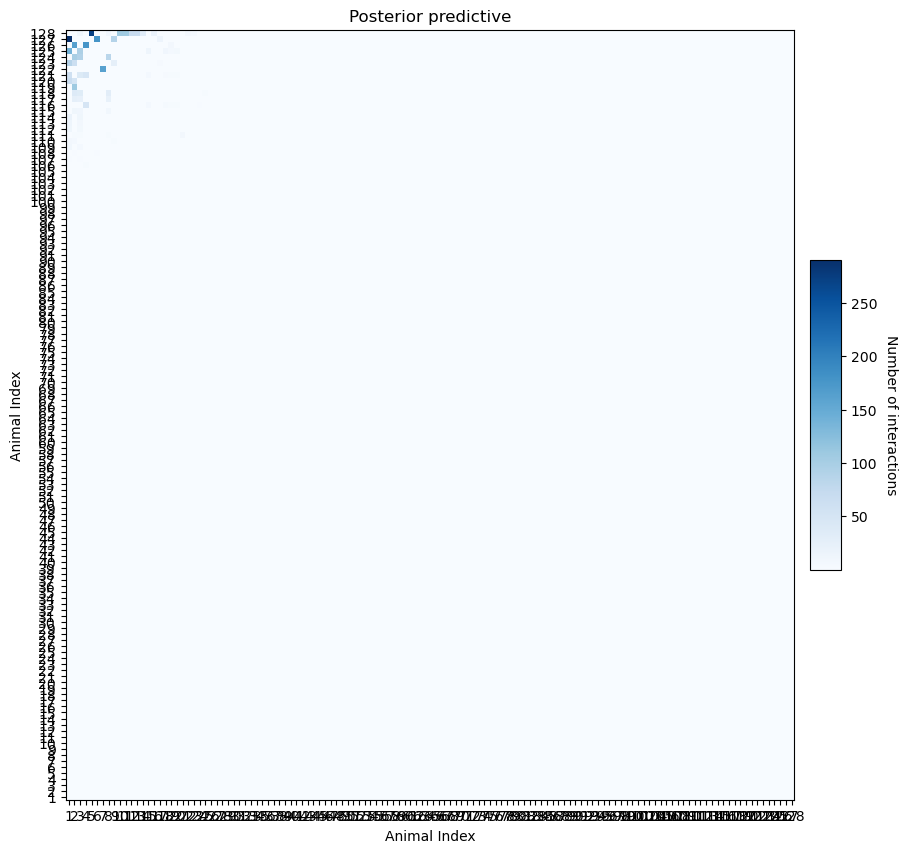

In [18]:
plt.figure(figsize=(10,10))
plt.title('Input matrix')
plt.pcolormesh(M, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Animal Index')
plt.ylabel('Animal Index')
plt.figure(figsize=(10,10))
plt.title('Posterior predictive')
plt.pcolormesh(M_tilde, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Animal Index')
plt.ylabel('Animal Index')
plt.show()


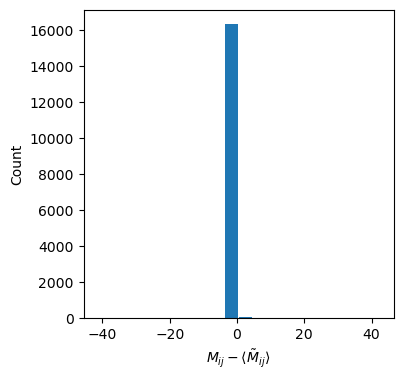

In [19]:
plt.figure(figsize=(4,4))
plt.hist((M-M_tilde).flatten(), density=False, bins=20, rwidth=0.9);

plt.xlabel(r'$M_{ij}-\langle \tilde{M}_{ij}\rangle$')
plt.ylabel('Count')
plt.show()

Or compare the posterior predictive value to the input directly:

In [20]:
posterior_samples = pp.get_posteriors_predictive_matrices(samples)

# Calculate the 97.5th percentile along the first axis (axis=0)
upper_bound_matrix = np.percentile(posterior_samples, 97.5, axis=0)

# Calculate the 2.5th percentile along the first axis (axis=0)
lower_bound_matrix = np.percentile(posterior_samples, 2.5, axis=0)


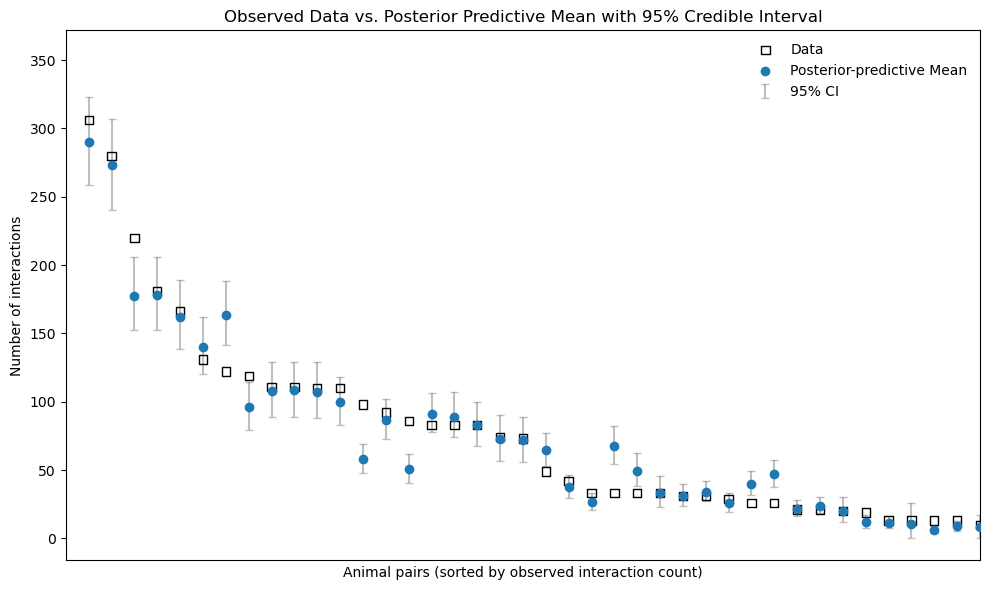

In [21]:
plt.figure(figsize=(10, 6)) 
sort_order = np.argsort(-M.flatten()) 

M_flat_sorted = M.flatten()[sort_order]
M_tilde_mean_flat_sorted = M_tilde.flatten()[sort_order]
lower_bounds_flat_sorted = lower_bound_matrix.flatten()[sort_order]
upper_bounds_flat_sorted = upper_bound_matrix.flatten()[sort_order]

lower_errors = M_tilde_mean_flat_sorted - lower_bounds_flat_sorted
upper_errors = upper_bounds_flat_sorted - M_tilde_mean_flat_sorted
yerr_values = [lower_errors, upper_errors]

x_values = range(1, len(sort_order) + 1)


plt.scatter(x_values, M_flat_sorted, marker='s', facecolors='none', edgecolors='k', label='Data', zorder=5) 
plt.scatter(x_values, M_tilde_mean_flat_sorted, label='Posterior-predictive Mean', zorder=10) 

plt.errorbar(x_values, M_tilde_mean_flat_sorted, yerr=yerr_values, fmt='none', 
             capsize=3, color='gray', alpha=0.5, label='95% CI', zorder=0) 


plt.xlim(0,40)

plt.xticks([]) 

plt.xlabel('Animal pairs (sorted by observed interaction count)')
plt.ylabel(r'Number of interactions')

min_y = min(M_flat_sorted.min(), lower_bounds_flat_sorted.min())
max_y = max(M_flat_sorted.max(), upper_bounds_flat_sorted.max())

plt.ylim(min_y - abs(min_y)*0.1 - (max_y - min_y)*0.05, max_y + abs(max_y)*0.1 + (max_y - min_y)*0.05)
plt.legend(frameon=False, markerfirst=True, loc='upper right') 

plt.title('Observed Data vs. Posterior Predictive Mean with 95% Credible Interval')
plt.tight_layout()
plt.show()

All these point of view confirm one thing: The model fits well.

Which means we're ready to calculate some estimates.

In [22]:
X_2=np.sum((M-M_tilde)**2/M_tilde)
print(f"\nCalculated Discrepancy (X^2): {round(X_2,2)}")
from scipy.stats import chi2
num_simulations=10000
degrees_of_freedom = n_p * n_a

  # Generate random samples from the chi-square distribution
chi_samples = chi2.rvs(df=degrees_of_freedom, size=num_simulations)

  # Estimate the expected value as the mean of the samples
estimated_expected_value = np.mean(chi_samples)

print(f"\nIf Estimated Discrepancy (X^2) is lower than: {round(np.percentile(chi_samples,5),2)}")
print(", we can affirm with 95% confidence or more that our model is better than a random/obsolete model")
print(f"\nExpected Discrepancy (X^2): {round(estimated_expected_value,2)}")


Calculated Discrepancy (X^2): 1018.24

If Estimated Discrepancy (X^2) is lower than: 16083.84
, we can affirm with 95% confidence or more that our model is better than a random/obsolete model

Expected Discrepancy (X^2): 16385.41


In [23]:
edge_prob = pp.estimate_network(samples)

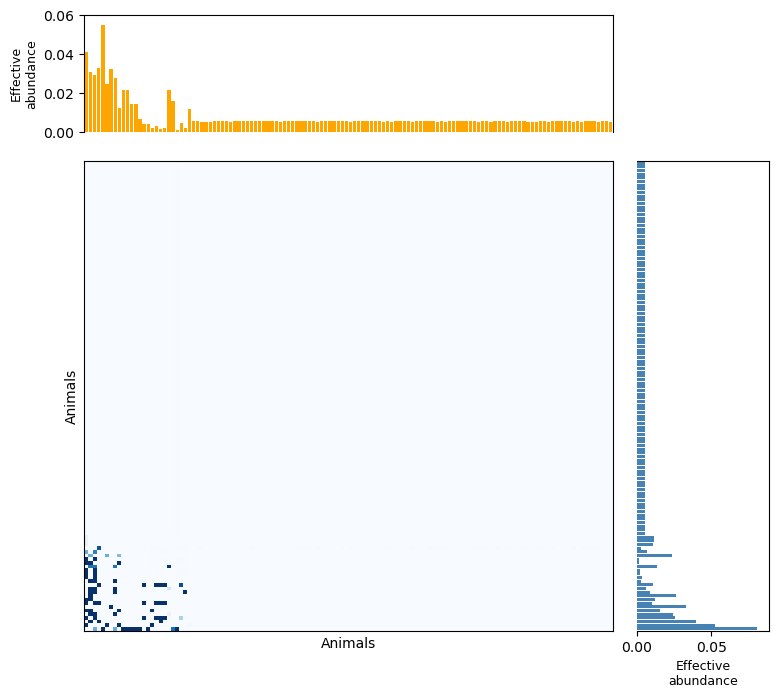

In [24]:
pp.figure_1_c(samples,n_a,n_p)

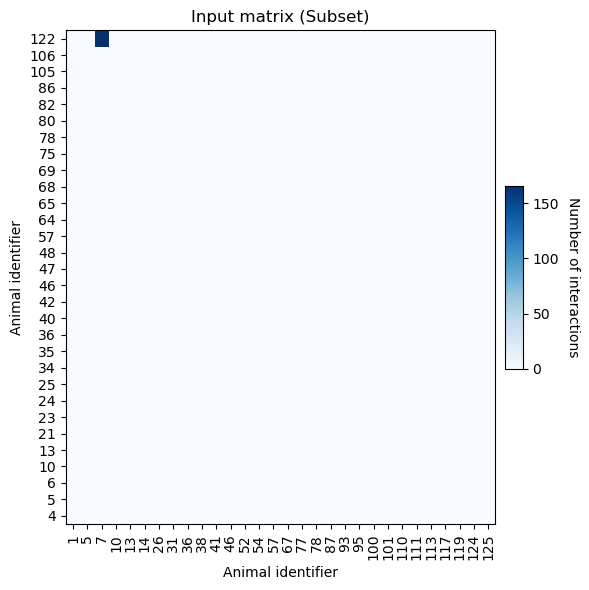

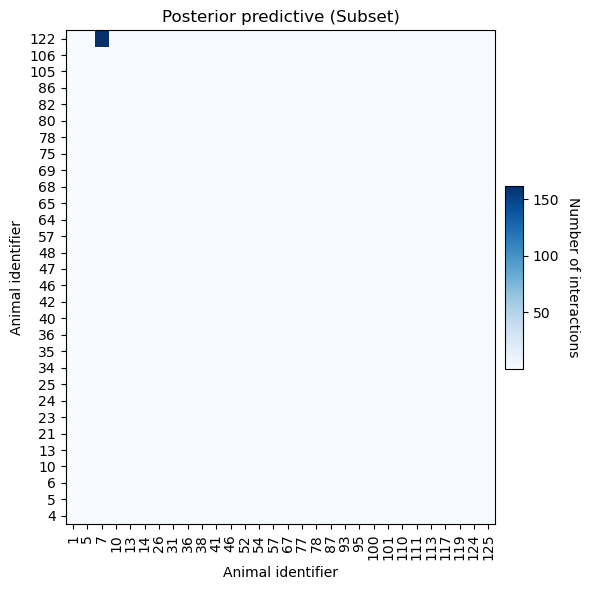

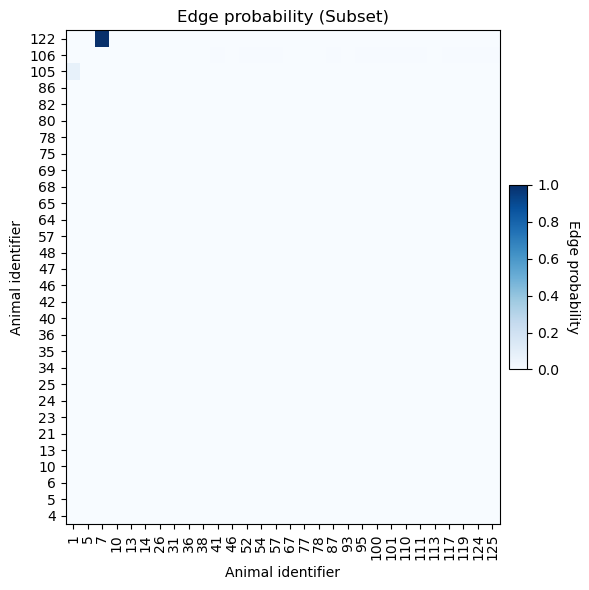

In [25]:
# Define the desired subset size
subset_animals = 30


# Call the plotting function
pp.plot_subset_interaction_matrices(
    M, 
    M_tilde, 
    edge_prob, 
    n_p, 
    n_a, 
    subset_animals, 
    subset_animals
)

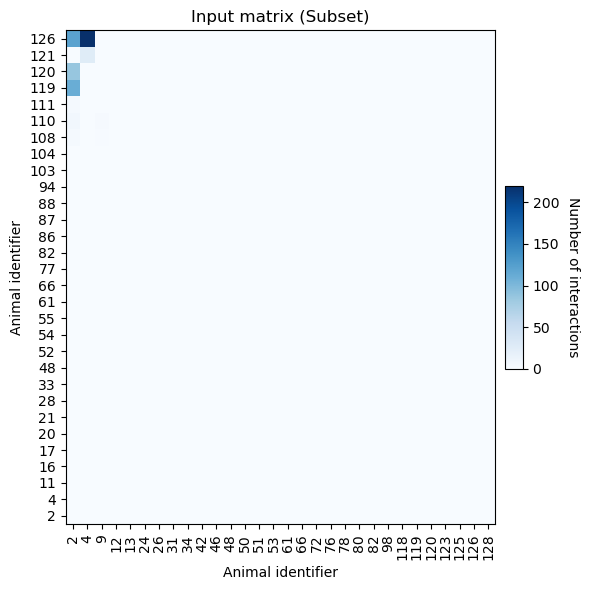

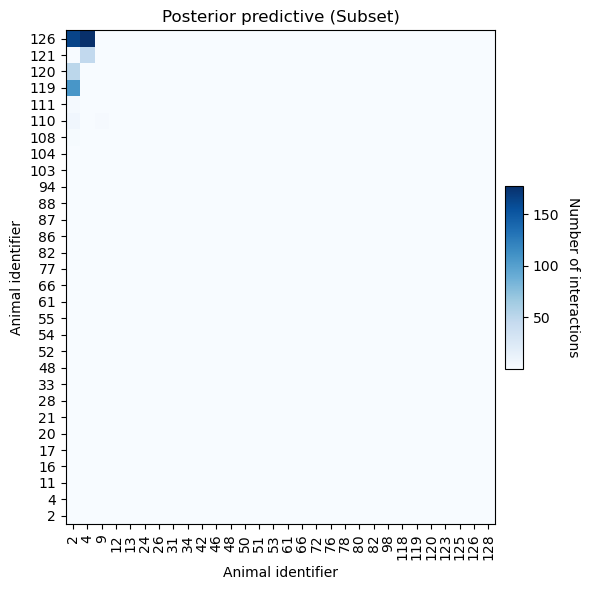

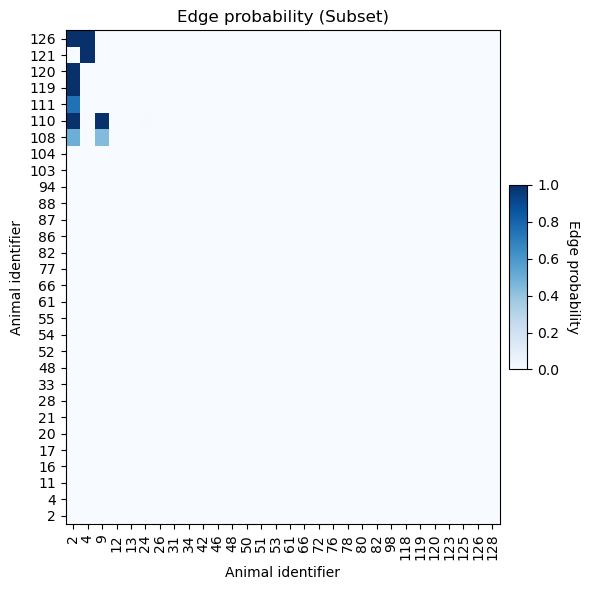

In [26]:
# Define the desired subset size
subset_animals = 30


# Call the plotting function
pp.plot_subset_interaction_matrices(
    M, 
    M_tilde, 
    edge_prob, 
    n_p, 
    n_a, 
    subset_animals, 
    subset_animals
)

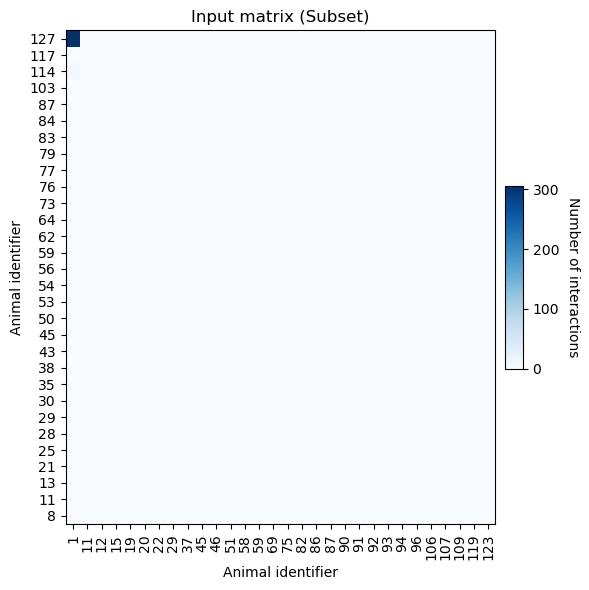

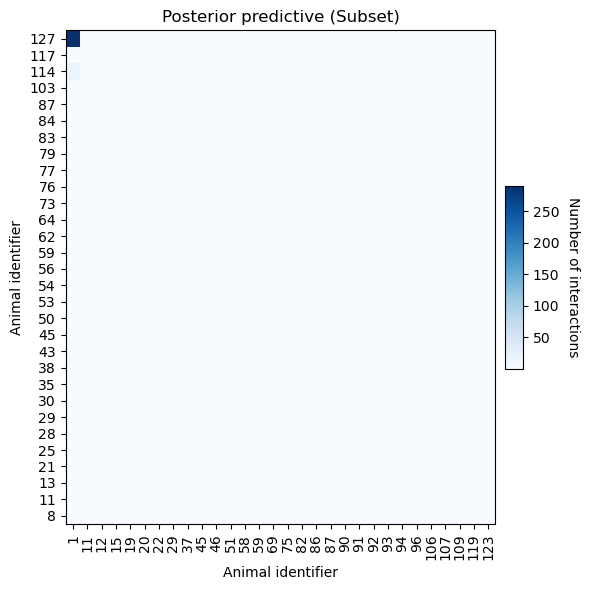

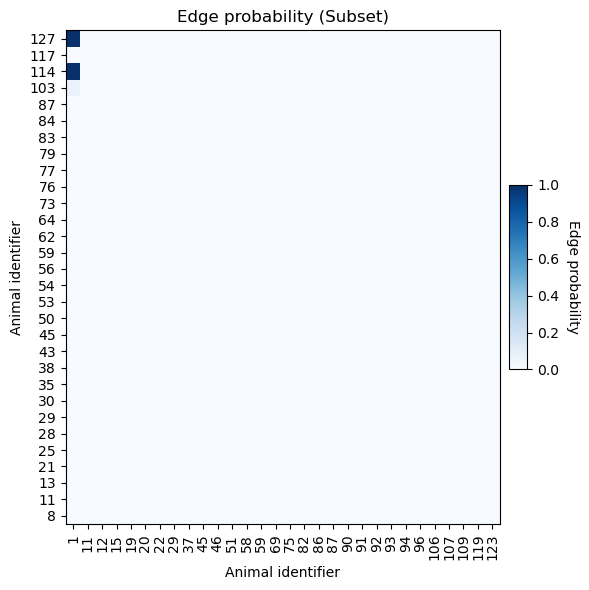

In [27]:
# Define the desired subset size
subset_animals = 30


# Call the plotting function
pp.plot_subset_interaction_matrices(
    M, 
    M_tilde, 
    edge_prob, 
    n_p, 
    n_a, 
    subset_animals, 
    subset_animals
)

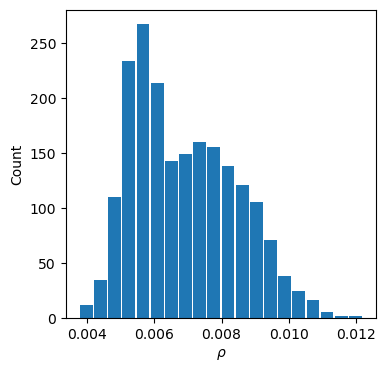

In [28]:
plt.figure(figsize=(4,4))
plt.hist(samples['rho'], density=False, bins=20, rwidth=0.9);

plt.xlabel(r'$\rho$')
plt.ylabel('Count')
plt.show()

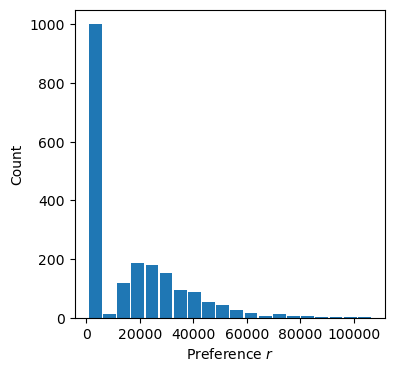

In [29]:
plt.figure(figsize=(4,4))
plt.hist(samples['r'], density=False, bins=20, rwidth=0.9);

plt.xlabel(r'Preference $r$')
plt.ylabel('Count')
plt.show()

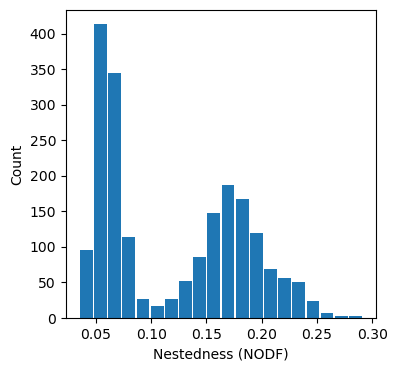

In [30]:
from scipy.stats import bernoulli
edge_probability_matrices=pp.estimate_networks(samples)

for i in range(edge_probability_matrices.shape[0]):
    edge_probability_matrices[i,:,:]=bernoulli.rvs(edge_probability_matrices[i,:,:])

nodf_values=np.zeros(edge_probability_matrices.shape[0])

for i in range(edge_probability_matrices.shape[0]):
    nodf_values[i] = pp.compute_nodf(edge_probability_matrices[i,:,:])

plt.figure(figsize=(4,4))
plt.hist(nodf_values, density=False, bins=20, rwidth=0.9);

plt.xlabel("Nestedness (NODF)")
plt.ylabel('Count')
plt.show()

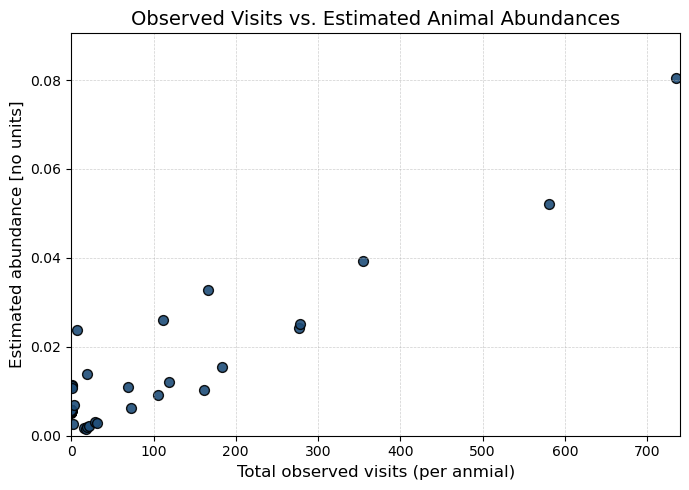

In [31]:
# Compute observed total visits per animal (row sums of the M matrix)
observed_visits = M.sum(axis=1)  # M is the observed animal–animal interaction matrix

# Compute posterior mean of sigma for each animal
sigma_mean = samples['sigma'].mean(axis=0)

# Plotting
fig, ax = plt.subplots(figsize=(7, 5))

ax.scatter(
    observed_visits,
    sigma_mean,
    s=50,
    color="#1f4e79",
    edgecolor="black",
    alpha=0.9
)

# Axis labeling and formatting
ax.set_title("Observed Visits vs. Estimated Animal Abundances", fontsize=14)
ax.set_xlabel("Total observed visits (per anmial)", fontsize=12)
ax.set_ylabel("Estimated abundance [no units]", fontsize=12)
ax.set_xlim(0, observed_visits.max() + 5)
ax.set_ylim(0, max(sigma_mean) + 0.01)
ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
ax.tick_params(axis='both', labelsize=10)

plt.tight_layout()
plt.show()

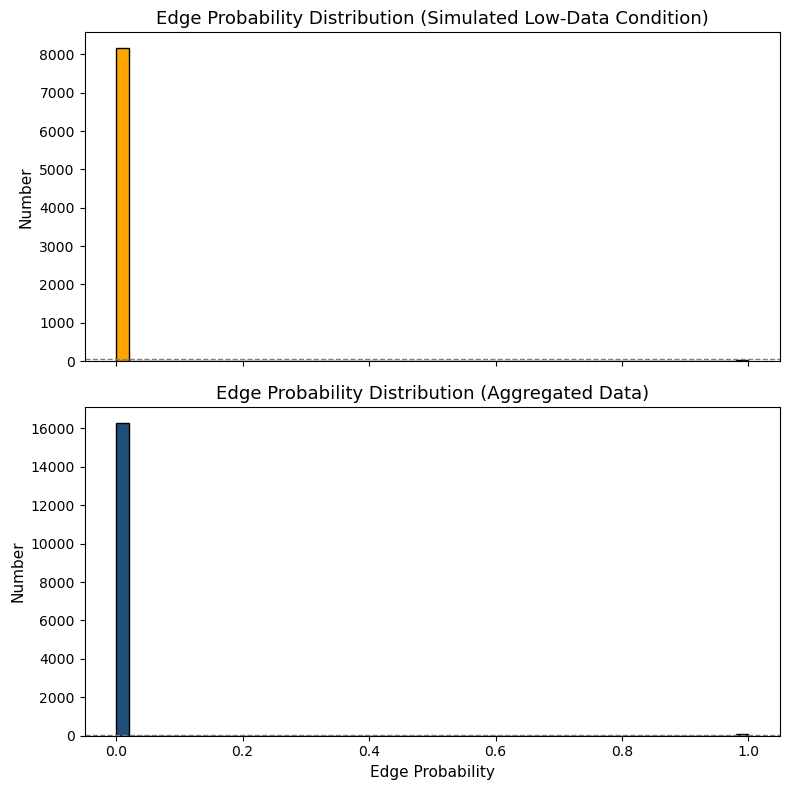

In [32]:
# Simulate a low-data condition by subsampling rows
M_sub, sub_idx = pp.subsample_matrix(M, frac=0.5)
sigma_samples_sub = [sigma[sub_idx] for sigma in samples['sigma']]

# Compute posterior edge probabilities
Q_sub = pp.average_edge_probs(M_sub, samples['C'], samples['r'], samples['rho'], sigma_samples_sub, samples['tau'])
Q_full = pp.average_edge_probs(M, samples['C'], samples['r'], samples['rho'], samples['sigma'], samples['tau'])

# Flatten for plotting
qvals_sub = Q_sub.flatten()
qvals_full = Q_full.flatten()

# Plot histograms
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# Figure 4a – subsampled (orange bars)
ax1.hist(qvals_sub, bins=50, color="orange", edgecolor='black')
ax1.axhline(50, color='gray', linestyle='--', linewidth=1)
ax1.set_title("Edge Probability Distribution (Simulated Low-Data Condition)", fontsize=13)
ax1.set_ylabel("Number", fontsize=11)

# Figure 4b – full data (blue bars)
ax2.hist(qvals_full, bins=50, color="#1f4e79", edgecolor='black')
ax2.axhline(50, color='gray', linestyle='--', linewidth=1)
ax2.set_title("Edge Probability Distribution (Aggregated Data)", fontsize=13)
ax2.set_xlabel("Edge Probability", fontsize=11)
ax2.set_ylabel("Number", fontsize=11)

plt.tight_layout()
plt.show()